In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import time
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.decomposition import PCA

In [33]:
def extract_PCA(input_features,nPCA,first_feat_to_keep=0):
    since = time.time()
    pca = PCA(n_components=nPCA)
    pca_feats = pca.fit_transform(input_features)
    time_elapsed = time.time() - since
    print('PCA extraction complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return pca_feats[:,first_feat_to_keep:]

def train_SVM(x,y,kernel,random_state):
    print('Starting SVM training')
    since = time.time()
    classifier = SVC(kernel = kernel, random_state = random_state)
    classifier.fit(x, y)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return classifier

In [29]:
# Load data
# pdir = 'C:/Users/tdkev/OneDrive - Johns Hopkins/Deep learning SP21 Project/Data_lite/'
# X = pickle.load(open(pdir+"X_esm_rev_2000.pickle", "rb"))
# y = pickle.load(open(pdir+"y_esm_rev_2000.pickle", "rb"))

pdir = 'C:/Users/tdkev/OneDrive - Johns Hopkins/Deep learning SP21 Project/Data_Balanced_6000/'
X = pickle.load(open(pdir+"X_rus.pickle", "rb"))
y = pickle.load(open(pdir+"y_rus.pickle", "rb"))

# Split into test and training sets
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)

# Reshape images into vectors
X_train = np.array(X_train).reshape(int(6000*0.8),-1)
X_test = np.array(X_test).reshape(int(6000*0.2),-1)

# normalize with feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [30]:
print(np.shape(X))
print(np.shape(y))
print('train size:',np.shape(X_train),np.shape(y_train))
print('test size:',np.shape(X_test),np.shape(y_test))

(6000, 151552)
(6000,)
train size: (4800, 151552) (4800,)
test size: (1200, 151552) (1200,)


In [31]:
# Fit SVM w/o PCA **~12 min**
kernel = 'rbf'
random_state = 0
classifier = train_SVM(X_train,y_train,kernel,random_state)

# save the model to disk
filename = 'svm_models/model_full_image_vectors_balanced.sav'
pickle.dump(classifier, open(filename, 'wb'))

classifier = pickle.load(open(filename, 'rb'))
# Predict test set
y_pred = classifier.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test,y_pred)

Starting SVM training
Training complete in 26m 33s
[[137  45  55  47]
 [ 88 120  65  27]
 [ 56  39 154  62]
 [ 56  22  76 151]]


0.4683333333333333

In [6]:
filename = 'svm_models/model_full_image_vectors.sav'
classifier = pickle.load(open(filename, 'rb'))
# Predict test set
since = time.time()
y_pred = classifier.predict(X_test)
time_elapsed = time.time() - since
print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test,y_pred)

[[128  97  14   7]
 [ 54 226  17   2]
 [ 31  64  36   6]
 [ 28  38  23  29]]


0.52375

In [34]:
acc_pca = []
kernel = 'rbf'
random_state = 0
first_feat_to_keep = 3 # Remove first 3 PCA features (0,1,2)
for i in range(50,501,50):
    nPCA = i
    print('*'*10+"Extracting "+str(i)+" PCA Features"+'*'*10)
    X_train_pca = extract_PCA(X_train,nPCA,first_feat_to_keep)
    X_test_pca = extract_PCA(X_test,nPCA,first_feat_to_keep)

    classifier_pca = train_SVM(X_train_pca,y_train,kernel,random_state)
    y_pred_pca = classifier_pca.predict(X_test_pca)

    # save the model to disk
    filename = 'svm_models/balanced_model_pca_'+str(i)+'.sav'
    pickle.dump(classifier_pca, open(filename, 'wb'))
    # load the model from disk
    # loaded_model = pickle.load(open(filename, 'rb'))

    # Compute confusion matrix
    cm_pca = confusion_matrix(y_test, y_pred_pca)
    print(cm_pca)
    acc = accuracy_score(y_test,y_pred_pca)
    print(acc)
    acc_pca.append(acc)

print(acc_pca)

**********Extracting 50 PCA Features**********
PCA extraction complete in 1m 46s
PCA extraction complete in 0m 15s
Starting SVM training
Training complete in 0m 2s
[[ 68  87  93  36]
 [ 90  75 107  28]
 [106  74  89  42]
 [ 73  98  87  47]]
0.2325
**********Extracting 100 PCA Features**********
PCA extraction complete in 1m 39s
PCA extraction complete in 0m 18s
Starting SVM training
Training complete in 0m 2s
[[109  78  65  32]
 [141  47  86  26]
 [ 98  65 111  37]
 [ 97  75  73  60]]
0.2725
**********Extracting 150 PCA Features**********
PCA extraction complete in 1m 28s
PCA extraction complete in 0m 18s
Starting SVM training
Training complete in 0m 2s
[[115  79  66  24]
 [139  56  84  21]
 [ 96  75 115  25]
 [104  54  95  52]]
0.2816666666666667
**********Extracting 200 PCA Features**********
PCA extraction complete in 1m 34s
PCA extraction complete in 0m 22s
Starting SVM training
Training complete in 0m 2s
[[121  77  59  27]
 [154  49  73  24]
 [108  58 113  32]
 [114  38  94  59]]


In [35]:
acc_pca_all = []
kernel = 'rbf'
random_state = 0
first_feat_to_keep = 0 # Keep all PCA features
for i in range(50,501,50):
    nPCA = i
    print('*'*10+"Extracting "+str(i)+" PCA Features"+'*'*10)
    X_train_pca = extract_PCA(X_train,nPCA,first_feat_to_keep)
    X_test_pca = extract_PCA(X_test,nPCA,first_feat_to_keep)

    classifier_pca = train_SVM(X_train_pca,y_train,kernel,random_state)
    y_pred_pca = classifier_pca.predict(X_test_pca)

    # save the model to disk
    filename = 'svm_models/balanced_model_pca_all_'+str(i)+'.sav'
    pickle.dump(classifier_pca, open(filename, 'wb'))
    # load the model from disk
    # loaded_model = pickle.load(open(filename, 'rb'))

    # Compute confusion matrix
    cm_pca = confusion_matrix(y_test, y_pred_pca)
    print(cm_pca)
    acc = accuracy_score(y_test,y_pred_pca)
    print(acc)
    acc_pca_all.append(acc)

print(acc_pca_all)

**********Extracting 50 PCA Features**********
PCA extraction complete in 0m 57s
PCA extraction complete in 0m 14s
Starting SVM training
Training complete in 0m 2s
[[118  59  62  45]
 [126  46  78  50]
 [105  60  79  67]
 [102  37  53 113]]
0.2966666666666667
**********Extracting 100 PCA Features**********
PCA extraction complete in 1m 9s
PCA extraction complete in 0m 18s
Starting SVM training
Training complete in 0m 2s
[[118  74  43  49]
 [129  55  62  54]
 [100  71  89  51]
 [134  55  46  70]]
0.27666666666666667
**********Extracting 150 PCA Features**********
PCA extraction complete in 1m 20s
PCA extraction complete in 0m 17s
Starting SVM training
Training complete in 0m 2s
[[121  76  40  47]
 [124  55  69  52]
 [ 97  73  89  52]
 [133  49  46  77]]
0.285
**********Extracting 200 PCA Features**********
PCA extraction complete in 1m 29s
PCA extraction complete in 0m 21s
Starting SVM training
Training complete in 0m 3s
[[130  70  39  45]
 [134  59  58  49]
 [103  73  83  52]
 [136  48

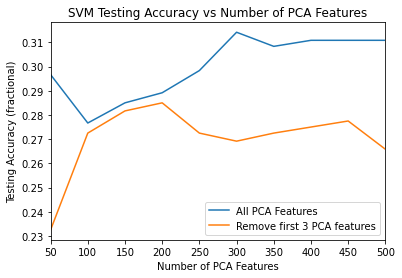

In [36]:
plt.figure()
plt.plot(range(50,501,50),acc_pca_all)
plt.plot(range(50,501,50),acc_pca)
plt.xlabel('Number of PCA Features')
plt.xlim((50,500))
plt.ylabel('Testing Accuracy (fractional)')
plt.title('SVM Testing Accuracy vs Number of PCA Features')
plt.legend(['All PCA Features','Remove first 3 PCA features'])
plt.show()